In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
# df = pd.read_excel("../data/Coffee Shop Sales.xlsx", engine='openpyxl')
# df.to_csv('../data/Coffee Shop Sales.csv', index=False)
df = pd.read_csv("../data/Coffee Shop Sales.csv")
df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [121]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_id    149116 non-null  int64  
 1   transaction_date  149116 non-null  object 
 2   transaction_time  149116 non-null  object 
 3   transaction_qty   149116 non-null  int64  
 4   store_id          149116 non-null  int64  
 5   store_location    149116 non-null  object 
 6   product_id        149116 non-null  int64  
 7   unit_price        149116 non-null  float64
 8   product_category  149116 non-null  object 
 9   product_type      149116 non-null  object 
 10  product_detail    149116 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 12.5+ MB


transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

In [122]:
# Create a new column for total trasaction value (sales)
df["sales"] = df["transaction_qty"] * df["unit_price"]

# I convert the time column to string first to ensure consistency, then calculate hour
df["transaction_hour"] = (
    df["transaction_time"].astype(str).str.split(":").str[0].astype(int)
)

df[
    ["transaction_time", "transaction_hour", "transaction_qty", "unit_price", "sales"]
].head()

,transaction_time,transaction_hour,transaction_qty,unit_price,sales
0,07:06:11,7,2,3.0,6.0
1,07:08:56,7,2,3.1,6.2
2,07:14:04,7,2,4.5,9.0
3,07:20:24,7,1,2.0,2.0
4,07:22:41,7,2,3.1,6.2


In [123]:
# Get summary statistics for numerical columns
# This helps identify outliers (e.g., negative quantity or extreme prices)
df.describe()

,transaction_id,transaction_qty,store_id,product_id,unit_price,sales,transaction_hour
count,149116.000000,149116.000000,149116.000000,149116.000000,149116.000000,149116.000000,149116.000000
mean,74737.371872,1.438276,5.342063,47.918607,3.382219,4.686367,11.735790
std,43153.600016,0.542509,2.074241,17.930020,2.658723,4.227099,3.764662
min,1.000000,1.000000,3.000000,1.000000,0.800000,0.800000,6.000000
25%,37335.750000,1.000000,3.000000,33.000000,2.500000,3.000000,9.000000
50%,74727.500000,1.000000,5.000000,47.000000,3.000000,3.750000,11.000000
75%,112094.250000,2.000000,8.000000,60.000000,3.750000,6.000000,15.000000
max,149456.000000,8.000000,8.000000,87.000000,45.000000,360.000000,20.000000


In [124]:
# how many transactions included multiple items
transaction_counts = df["transaction_id"].value_counts()

# oders with more than 1 item
multi_item_txns = transaction_counts[transaction_counts > 1]

print(f"there are {len(multi_item_txns)} orders that included more than 1 item.")

there are 0 orders that included more than 1 item.


Notice that each transaction ID only includes 1 product type, we need to restore real order ID by transaciton time.

In [125]:
# [Data Cleaning Step] Constructing the Real Basket ID

# 1. 备份原始 ID (可选，以防万一后续要用行号)
# df['line_item_id'] = df['transaction_id']

# 2. 核心逻辑：用“门店 + 日期 + 时间”合成唯一的订单 ID
# 为什么加门店？防止不同分店在同一秒钟都有订单，导致 ID 冲突。
df["basket_id"] = (
    df["store_location"].astype(str)
    + "_"
    + df["transaction_date"].astype(str)
    + "_"
    + df["transaction_time"].astype(str)
)
# 3. 基础计数
total_rows = len(df)  # 总行数 (Total Line Items)
total_baskets = df["basket_id"].nunique()  # 总单数 (Total Real Orders)
total_units = df["transaction_qty"].sum()  # 总件数 (Total Units Sold)

# 4. 计算两个不同的指标
avg_types_per_basket = total_rows / total_baskets  # 平均每单买几种 (1.28)
avg_units_per_basket = total_units / total_baskets  # 平均每单买几件 (Real UPT)

# 5. 打印修正后的报告
print(f"🧹 Data Cleaning Report (Corrected):")
print(f"-----------------------------------")
print(f"Total Unique Baskets     : {total_baskets:,}")
print(f"Total Line Items (Rows)  : {total_rows:,}")
print(f"Total Units Sold (Qty)   : {total_units:,}")
print(f"-----------------------------------")
print(f"📊 Basket Depth Analysis:")
print(f"   - Avg TYPES per Basket: {avg_types_per_basket:.2f} (Line Depth)")
print(f"   - Avg UNITS per Basket: {avg_units_per_basket:.2f} (Real UPT)")

# 6. 看看“同品多件”的贡献
# 如果 Avg Units 比 Avg Types 高很多，说明大家喜欢一次买好几杯同样的咖啡
multi_unit_boost = (total_units - total_rows) / total_baskets
print(f"   - 'Same-Item' Boost   : +{multi_unit_boost:.2f} units/order")

🧹 Data Cleaning Report (Corrected):
-----------------------------------
Total Unique Baskets     : 116,790
Total Line Items (Rows)  : 149,116
Total Units Sold (Qty)   : 214,470
-----------------------------------
📊 Basket Depth Analysis:
   - Avg TYPES per Basket: 1.28 (Line Depth)
   - Avg UNITS per Basket: 1.84 (Real UPT)
   - 'Same-Item' Boost   : +0.56 units/order


It means there will be 1 in 4 customers (28%) who will buy a different type of items with the first type. And there will be 1 in 2 customers (56%) who buy a second item along with the first one in a same type. 

It shows that more than half of the customers will buy more than 1 item in the same type, probably buying for their colleges or friends.

Unique combinations of product_detail and unit_price

In [126]:
df[["product_detail", "unit_price"]].drop_duplicates().sort_values("product_detail")

,product_detail,unit_price
88852,Almond Croissant,4.69
102,Almond Croissant,3.75
3451,Brazilian - Organic,18.00
32,Brazilian Lg,3.50
31,Brazilian Rg,3.00
...,...,...
19,Sustainably Grown Organic Lg,4.75
41,Sustainably Grown Organic Rg,3.75
3896,Traditional Blend Chai,8.95
60,Traditional Blend Chai Lg,3.00


* *Price Outlier Analysis*

There are only 80 product detail (80 kinds of product), but there are 98 prices in total. There are 18 extra prices.

In [127]:
# 1. 找出每个商品有几个“不同的价格”
# 也就是你说的：先由 product 和 price 组合，然后数数
product_pricing = df.groupby("product_detail")["unit_price"].unique()

# 2. 筛选出那些“不老实”的（价格数量 > 1 的商品）
# 这些就是导致 80 变成 98 的原因
multi_priced_items = product_pricing[product_pricing.apply(len) > 1]

print(f"📊 Price Variance Report:")
print(f"-------------------------")
print(f"Total Products Checked : {len(product_pricing)}")
print(f"Products with >1 Price : {len(multi_priced_items)} (Expected ~18)")
print(f"-------------------------\n")

print("📋 The 'Hidden Size' Detective:")
print("(These products depend on size/location for pricing)")

# 3. 打印详情
for product, prices in multi_priced_items.items():
    # 排序，从小到大显示，方便看出是不是 $0.5 的升杯差价
    sorted_prices = sorted(prices)

    # 算出差价 (Gap)
    gap = sorted_prices[-1] - sorted_prices[0]

    price_str = ", ".join([f"${p:.2f}" for p in sorted_prices])
    print(f"🔹 {product:<25} : {price_str} \t(Gap: ${gap:.2f})")

# 4. 验证是否是“地点”造成的 (Location Check)
# 挑出第一个多价商品，看看它的价格分布是否跟门店有关
if len(multi_priced_items) > 0:
    target_product = multi_priced_items.index[0]
    print(f"\n🌍 Location Check for [{target_product}]:")
    # 交叉表：看每个门店卖这个商品是卖哪个价格
    loc_check = pd.crosstab(
        df[df["product_detail"] == target_product]["store_location"],
        df[df["product_detail"] == target_product]["unit_price"],
    )
    print(loc_check)

📊 Price Variance Report:
-------------------------
Total Products Checked : 80
Products with >1 Price : 15 (Expected ~18)
-------------------------

📋 The 'Hidden Size' Detective:
(These products depend on size/location for pricing)
🔹 Almond Croissant          : $3.75, $4.69 	(Gap: $0.94)
🔹 Chocolate Chip Biscotti   : $3.50, $4.38 	(Gap: $0.88)
🔹 Chocolate Croissant       : $3.75, $4.69 	(Gap: $0.94)
🔹 Cranberry Scone           : $3.25, $4.06 	(Gap: $0.81)
🔹 Croissant                 : $3.50, $4.38 	(Gap: $0.88)
🔹 Ginger Biscotti           : $3.50, $4.38 	(Gap: $0.88)
🔹 Ginger Scone              : $2.65, $3.25, $4.06 	(Gap: $1.41)
🔹 Hazelnut Biscotti         : $3.25, $4.06 	(Gap: $0.81)
🔹 I Need My Bean! Diner mug : $12.00, $23.00 	(Gap: $11.00)
🔹 I Need My Bean! Latte cup : $14.00, $23.00 	(Gap: $9.00)
🔹 I Need My Bean! T-shirt   : $23.00, $28.00 	(Gap: $5.00)
🔹 Jumbo Savory Scone        : $3.75, $4.69 	(Gap: $0.94)
🔹 Organic Decaf Blend       : $12.00, $22.50, $23.00, $28.00 	(Gap: $

I notice that most of the second price is 1.25 times of the first price and most of the products are bakery. Who pays the 25% markup?

In [128]:
# 1. Get unique prices for each product
# 获取每个商品的所有不同价格
product_prices = df.groupby("product_detail")["unit_price"].unique()

# 2. Filter logic
# 筛选逻辑：至少有2个价格，且 最高价/最低价 ≈ 1.25
matched_products = []

for product, prices in product_prices.items():
    if len(prices) >= 2:
        min_p = min(prices)
        max_p = max(prices)
        ratio = max_p / min_p

        # Check if ratio is close to 1.25 (allowing small rounding error)
        # 检查倍数是否在 1.24 到 1.26 之间
        if 1.24 <= ratio <= 1.26:
            matched_products.append(
                {
                    "Product": product,
                    "Base Price": min_p,
                    "Markup Price": max_p,
                    "Ratio": round(ratio, 4),
                }
            )

# 3. Create DataFrame and Show
# 生成结果表
result_df = pd.DataFrame(matched_products).sort_values(by="Product")

print(f"🎯 Found {len(result_df)} items with ~1.25x markup:")
print("-" * 50)
print(result_df)
print(result_df["Product"].tolist())

🎯 Found 9 items with ~1.25x markup:
--------------------------------------------------
                   Product  Base Price  Markup Price   Ratio
0         Almond Croissant        3.75          4.69  1.2507
1  Chocolate Chip Biscotti        3.50          4.38  1.2514
2      Chocolate Croissant        3.75          4.69  1.2507
3          Cranberry Scone        3.25          4.06  1.2492
4                Croissant        3.50          4.38  1.2514
5          Ginger Biscotti        3.50          4.38  1.2514
6        Hazelnut Biscotti        3.25          4.06  1.2492
7       Jumbo Savory Scone        3.75          4.69  1.2507
8    Scottish Cream Scone         4.50          5.63  1.2511
['Almond Croissant', 'Chocolate Chip Biscotti', 'Chocolate Croissant', 'Cranberry Scone', 'Croissant', 'Ginger Biscotti', 'Hazelnut Biscotti', 'Jumbo Savory Scone', 'Scottish Cream Scone ']


In [129]:
# 1. 选出那些被证实有 "1.25倍" 溢价的商品
# 我们用你在列表中发现的典型例子
targets = [
    "Almond Croissant",
    "Chocolate Chip Biscotti",
    "Chocolate Croissant",
    "Cranberry Scone",
    "Croissant",
    "Ginger Biscotti",
    "Hazelnut Biscotti",
    "Jumbo Savory Scone",
    "Scottish Cream Scone ",
]

# 2. 提取数据
evidence = df[df["product_detail"].isin(targets)]

# 3. 核心透视：地点 (Location) vs 价格 (Price)
# 我们不仅要看有没有，还要看数量 (Count)，看是不是混在一起
cross_exam = pd.crosstab(evidence["store_location"], evidence["unit_price"])

print("🕵️‍♂️ EVIDENCE BOARD: Price Distribution by Location")
print("--------------------------------------------------")
print(cross_exam)
print("--------------------------------------------------\n")

🕵️‍♂️ EVIDENCE BOARD: Price Distribution by Location
--------------------------------------------------
unit_price       3.25  3.50  3.75  4.06  4.38  4.50  4.69  5.63
store_location                                                 
Astoria          1315  1821  2298     0     0   570     0     0
Hell's Kitchen   1375  1812  2295     0     0   781     0     0
Lower Manhattan  1351  1947  2352    45    55   586    42    15
--------------------------------------------------



Seems like lower manhattan have multiple unit prices for some products. Let's go back to the raw data of these orders and check how this happen.

In [130]:
import pandas as pd

# 1. 嫌疑人名单 (刚才确认的那 9 个面包)
target_products = [
    "Almond Croissant",
    "Chocolate Chip Biscotti",
    "Chocolate Croissant",
    "Cranberry Scone",
    "Croissant",
    "Ginger Biscotti",
    "Hazelnut Biscotti",
    "Jumbo Savory Scone",
    "Scottish Cream Scone",
]

# 2. 锁定“高价行” (The Trigger)
# 逻辑：在 Lower Manhattan，且价格是该商品在这个店里的"最高价"
# 我们先找到每个商品在 Lower Manhattan 的最高价
lm_df = df[df["store_location"] == "Lower Manhattan"]
high_price_map = (
    lm_df[lm_df["product_detail"].isin(target_products)]
    .groupby("product_detail")["unit_price"]
    .max()
)

# 筛选出符合高价的 Transaction ID
# 我们需要构建一个 filter，匹配 (Product == X) AND (Price == Max_Price_of_X)
suspect_ids = []

for product, high_price in high_price_map.items():
    # 找到这个商品卖高价的所有订单 ID
    ids = lm_df[
        (lm_df["product_detail"] == product) & (lm_df["unit_price"] == high_price)
    ]["transaction_id"].unique()

    suspect_ids.extend(ids)

# 去重 ID
suspect_ids = list(set(suspect_ids))

# 3. 还原完整订单 (The Full Scene)
# 从原始 df 中提取这些 ID 的所有行，看看他们整单都买了啥
# 这里的 df 是你的总表
suspicious_orders = df[df["transaction_id"].isin(suspect_ids)].copy()

# 排序：按 ID 和 行号/时间 排序，方便你看清一单里的东西
if "transaction_time" in df.columns:
    suspicious_orders = suspicious_orders.sort_values(
        by=["transaction_id", "transaction_time"]
    )
else:
    suspicious_orders = suspicious_orders.sort_values(by=["transaction_id"])

# 4. 展示结果
print(f"🕵️‍♂️ Found {len(suspect_ids)} suspicious transactions.")
print("Here is a sample of the raw data (Full Orders):")
print("-" * 80)

# 显示前 20 行，包含所有列
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
suspicious_orders

🕵️‍♂️ Found 142 suspicious transactions.
Here is a sample of the raw data (Full Orders):
--------------------------------------------------------------------------------


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,sales,transaction_hour,basket_id
4417,4447,2023-01-09,07:33:08,1,5,Lower Manhattan,75,4.38,Bakery,Pastry,Croissant,4.38,7,Lower Manhattan_2023-01-09_07:33:08
4447,4477,2023-01-09,07:52:52,1,5,Lower Manhattan,70,4.06,Bakery,Scone,Cranberry Scone,4.06,7,Lower Manhattan_2023-01-09_07:52:52
4457,4487,2023-01-09,07:57:11,1,5,Lower Manhattan,69,4.06,Bakery,Biscotti,Hazelnut Biscotti,4.06,7,Lower Manhattan_2023-01-09_07:57:11
4541,4571,2023-01-09,08:56:45,1,5,Lower Manhattan,76,4.38,Bakery,Biscotti,Chocolate Chip Biscotti,4.38,8,Lower Manhattan_2023-01-09_08:56:45
4562,4592,2023-01-09,09:09:38,1,5,Lower Manhattan,76,4.38,Bakery,Biscotti,Chocolate Chip Biscotti,4.38,9,Lower Manhattan_2023-01-09_09:09:38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123835,124172,2023-06-09,15:38:43,1,5,Lower Manhattan,79,4.69,Bakery,Scone,Jumbo Savory Scone,4.69,15,Lower Manhattan_2023-06-09_15:38:43
123918,124255,2023-06-09,17:38:33,1,5,Lower Manhattan,71,4.69,Bakery,Pastry,Chocolate Croissant,4.69,17,Lower Manhattan_2023-06-09_17:38:33
123966,124303,2023-06-09,18:28:56,1,5,Lower Manhattan,79,4.69,Bakery,Scone,Jumbo Savory Scone,4.69,18,Lower Manhattan_2023-06-09_18:28:56
124017,124354,2023-06-09,19:21:34,1,5,Lower Manhattan,69,4.06,Bakery,Biscotti,Hazelnut Biscotti,4.06,19,Lower Manhattan_2023-06-09_19:21:34


In [131]:
suspicious_orders["transaction_date"].value_counts()

transaction_date
2023-06-09    31
2023-05-09    28
2023-03-09    22
2023-04-09    19
2023-01-09    16
2023-02-09    16
2023-03-30     2
2023-03-31     2
2023-01-30     1
2023-01-31     1
2023-04-30     1
2023-05-30     1
2023-05-31     1
2023-06-30     1
Name: count, dtype: int64

All suspicious order happened on 9th, 30th and 31st of each months.

I want to see if all multiple price items happen in Lower Manhatten and on the same days.

We need to go back to the raw data of all multiple prices items.

In [132]:
# 1. 找出所有“价格不唯一”的商品
# 先按商品分组，看价格的唯一值数量
price_summary = df.groupby("product_detail")["unit_price"].nunique()
multi_price_products = price_summary[price_summary > 1].index

# 2. 统计这些商品的【价格 vs 销量】
# 只看嫌疑商品
suspect_df = df[df["product_detail"].isin(multi_price_products)]

# 核心：按 [商品, 价格] 聚合计数
# 这里的 'transaction_id' 计数代表订单数 (Frequency)
price_distribution = (
    suspect_df.groupby(["product_detail", "unit_price"])["transaction_id"]
    .count()
    .reset_index(name="Frequency")
)

# 3. 排序：让同一个商品的不用价格挨在一起，且按销量从高到低排
# 这样排在第一行的就是“原价”
price_distribution = price_distribution.sort_values(
    by=["product_detail", "Frequency"], ascending=[True, False]
)

# 4. 展示结果
print("📊 Price Frequency Analysis (Top counts = Real Price):")
print("-" * 60)
print(price_distribution)

📊 Price Frequency Analysis (Top counts = Real Price):
------------------------------------------------------------
               product_detail  unit_price  Frequency
0            Almond Croissant        3.75       1901
1            Almond Croissant        4.69          2
2     Chocolate Chip Biscotti        3.50       1874
3     Chocolate Chip Biscotti        4.38         17
4         Chocolate Croissant        3.75       3059
5         Chocolate Croissant        4.69         17
6             Cranberry Scone        3.25       2053
7             Cranberry Scone        4.06         24
8                   Croissant        3.50       1907
9                   Croissant        4.38         26
10            Ginger Biscotti        3.50       1799
11            Ginger Biscotti        4.38         12
13               Ginger Scone        3.25       2019
12               Ginger Scone        2.65        284
14               Ginger Scone        4.06         21
15          Hazelnut Biscotti        

In [133]:
# 1. 自动计算每个商品的“标准原价” (Base Price)
# 逻辑：对于每个商品，找出销量 (count) 最大的那个价格
price_counts = (
    df.groupby(["product_detail", "unit_price"]).size().reset_index(name="count")
)

# 按 [商品, 销量] 排序 (销量高的在上面)
base_price_df = price_counts.sort_values(
    by=["product_detail", "count"], ascending=[True, False]
)

# 去重：只保留每个商品的第一行 (也就是销量最高的那个价格)
base_price_map = base_price_df.drop_duplicates("product_detail")[
    ["product_detail", "unit_price"]
]
base_price_map.columns = ["product_detail", "base_price"]  # 重命名列

# 2. 将 Base Price 合并回主数据 df
# 现在你的 df 里会多出一列 'base_price'
df = df.merge(base_price_map, on="product_detail", how="left")

# 3. 创建标记列：是否为异常价格 (is_price_anomaly)
# 只要 实际卖价 != 标准原价，就标记为 True
df["is_price_anomaly"] = df["unit_price"] != df["base_price"]

# 4. 看看效果！
# 让我们检查一下那些“非原价”的单子现在长什么样
cols_to_show = [
    "transaction_date",
    "store_location",
    "product_detail",
    "unit_price",
    "base_price",
    "is_price_anomaly",
]

print("✅ Base Price Tagging Complete!")
print("Here are some examples of identified ANOMALIES:")
print("-" * 60)
print(df[df["is_price_anomaly"] == True][cols_to_show].head(10))

# 5. 最终统计：到底清洗出了多少“杂质”？
print("\n📊 Data Quality Report:")
print(f"Total Transactions : {len(df)}")
print(f"Clean (Base Price) : {len(df[df['is_price_anomaly']==False])}")
print(f"Anomalies (Markup/Discount) : {len(df[df['is_price_anomaly']==True])}")

✅ Base Price Tagging Complete!
Here are some examples of identified ANOMALIES:
------------------------------------------------------------
     transaction_date   store_location           product_detail  unit_price  base_price  is_price_anomaly
3296       2023-01-07  Lower Manhattan      Organic Decaf Blend       28.00       22.50              True
3302       2023-01-07  Lower Manhattan      Organic Decaf Blend       28.00       22.50              True
3408       2023-01-07  Lower Manhattan      Organic Decaf Blend       28.00       22.50              True
3448       2023-01-07  Lower Manhattan      Organic Decaf Blend       12.00       22.50              True
3571       2023-01-07  Lower Manhattan      Organic Decaf Blend       12.00       22.50              True
4417       2023-01-09  Lower Manhattan                Croissant        4.38        3.50              True
4447       2023-01-09  Lower Manhattan          Cranberry Scone        4.06        3.25              True
4457       2

# What time of the day has the highest sales?
Analyze hourly sales trends to identify peak shopping hours.

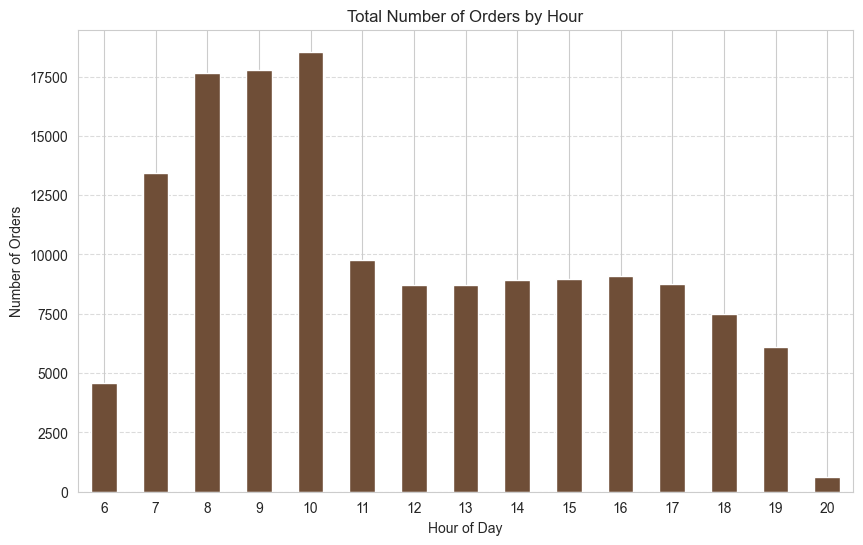

Busiest Hours (Order Counts):
transaction_hour
10    18545
9     17764
8     17654
Name: basket_id, dtype: int64


In [134]:
# group by hour and count transaction
hourly_counts = df.groupby("transaction_hour")["basket_id"].count()

# plot bar chart
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind="bar", color="#6f4e37")  # use coffee color

plt.title("Total Number of Orders by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# print out top 3 hours
print("Busiest Hours (Order Counts):")
print(hourly_counts.sort_values(ascending=False).head(3))

In [135]:
# 1. Calculate the number of unique days
num_days = df["transaction_date"].nunique()

# 2. Divide your existing hourly_counts by num_days to get the daily average
avg_hourly_counts = hourly_counts / num_days

# 3. Sort and print the top 3
top_3_hours = avg_hourly_counts.sort_values(ascending=False).head(3)

print("Top 3 Hours by Average Daily Transaction Volume:")
print(top_3_hours)

Top 3 Hours by Average Daily Transaction Volume:
transaction_hour
10    102.458564
9      98.143646
8      97.535912
Name: basket_id, dtype: float64


Peak Trading Hours Anlayisis

Observation：
As illustrated in the bar chart, sales volume is heavily concentrated in the morning hours. The peak trading period occurs between 8:00AM and 10:00AM, with the highest volume at 10:00AM (average about 102 transactions).



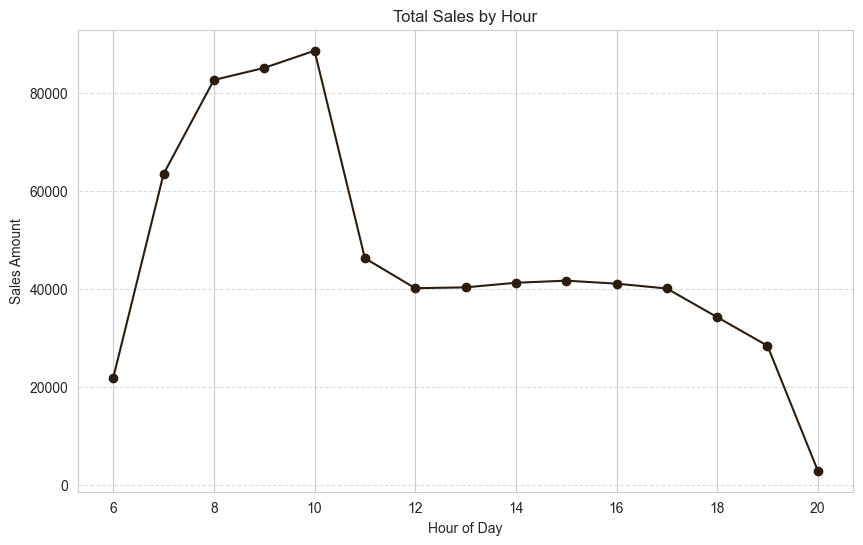

Highest Revenue Hours:
transaction_hour
10    88673.39
9     85169.53
8     82699.87
Name: sales, dtype: float64


In [136]:
# group by hour and count transaction
hourly_sales = df.groupby("transaction_hour")["sales"].sum()

# plot bar chart
plt.figure(figsize=(10, 6))
hourly_sales.plot(kind="line", color="#2c1d11", marker="o")  # use coffee color

plt.title("Total Sales by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Sales Amount")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

# print out top 3 hours
print("Highest Revenue Hours:")
print(hourly_sales.sort_values(ascending=False).head(3))

In [137]:
# Divide existing hourly_sales by num_days to get the daily average
avg_hourly_sales = hourly_sales / num_days

# 3. Sort and print the top 3
top_3_hours = avg_hourly_sales.sort_values(ascending=False).head(3)

print("Top 3 Hours by Average Daily Sales Amount:")
print(top_3_hours)

Top 3 Hours by Average Daily Sales Amount:
transaction_hour
10    489.908232
9     470.549890
8     456.905359
Name: sales, dtype: float64


Even though morning are the peak hours, but afternoon still creates about half of revenue of the peak hours.

We can dive deep into the specific product type and check on what time of the day each of the product sells the best.

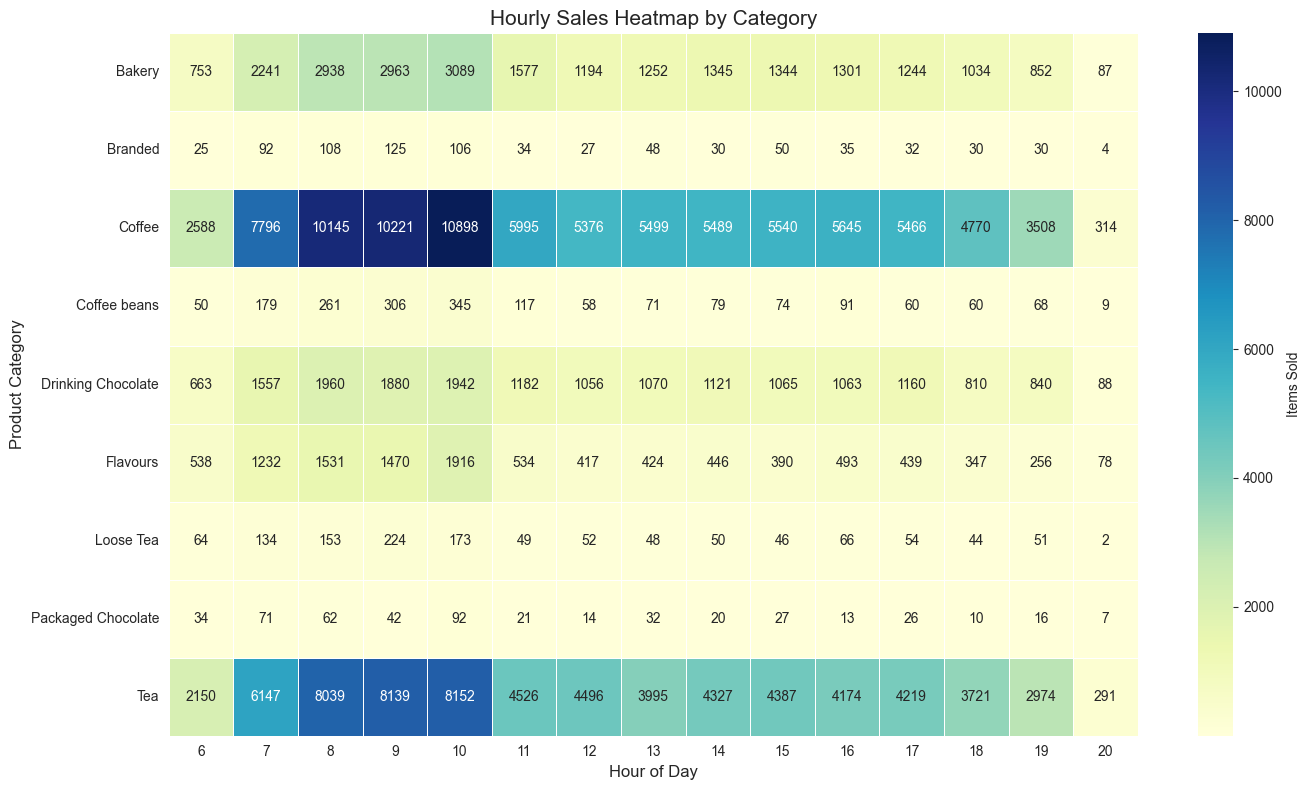

In [138]:
# 1. pivot table
heatmap_data = df.pivot_table(
    index="product_category",
    columns="transaction_hour",
    values="transaction_qty",
    aggfunc="sum",
    fill_value=0,  # 没卖出去的时段填0
)

# 2. plot
plt.figure(figsize=(14, 8))

sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    cbar_kws={"label": "Items Sold"},
)

plt.title("Hourly Sales Heatmap by Category", fontsize=15)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Product Category", fontsize=12)

plt.tight_layout()
plt.show()

In the morning, the best sellers are coffee and tea and bakery, which means customers buy breakfast from the coffee shop. How about the afternoon? What customer are buying and what created the revenue?

<Figure size 1200x600 with 0 Axes>

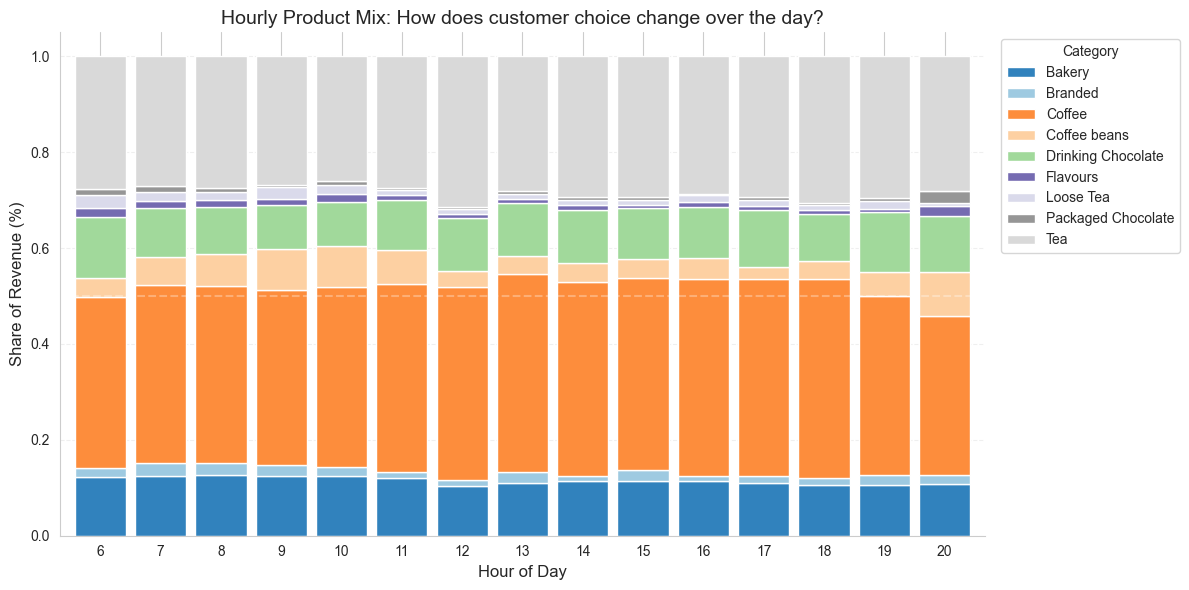

In [139]:
# pivot, sales
hourly_mix = df.pivot_table(
    index="transaction_hour", columns="product_category", values="sales", aggfunc="sum"
)

# 2. Normalize to 100%
hourly_mix_pct = hourly_mix.div(hourly_mix.sum(axis=1), axis=0)

# 3. Stacked Bar Chart
plt.figure(figsize=(12, 6))

# pandas plot(kind='bar', stacked=True)
ax = hourly_mix_pct.plot(
    kind="bar",
    stacked=True,
    width=0.85,
    colormap="tab20c",  # 选个颜色丰富的色盘
    figsize=(12, 6),
)

plt.title(
    "Hourly Product Mix: How does customer choice change over the day?", fontsize=14
)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Share of Revenue (%)", fontsize=12)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", title="Category")  # 图例放外面
plt.axhline(0.5, color="white", linestyle="--", alpha=0.3)  # 50% 中线

# rotate x axis
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.3)

sns.despine()

plt.tight_layout()
plt.show()

From the stacked bar chart, all category have similar share of revenue through out the day. It did not change by time.

# Which stores or regions perform best in terms of sales?
Compare total revenue and order volume across locations.

In [140]:
# 2. 重新聚合数据 (Group by Store)
new_store_perf = df.groupby("store_location").agg(
    total_revenue=("sales", "sum"),  # 总销售额（不变）
    total_items_sold=("transaction_qty", "sum"),  # 总销量（不变）
    real_order_count=("basket_id", "nunique"),  # 【变化点】真实的单量
)

# 3. 计算真实的 KPI
new_store_perf["Real_AOV"] = (
    new_store_perf["total_revenue"] / new_store_perf["real_order_count"]
)
new_store_perf["Real_UPT"] = (
    new_store_perf["total_items_sold"] / new_store_perf["real_order_count"]
)

# 4. 排序并展示
new_store_perf = new_store_perf.sort_values(by="total_revenue", ascending=False)

# 格式化展示
print("📊 RECALCULATED Store Performance (Based on Baskets):")
print("-" * 60)
print(new_store_perf[["total_revenue", "real_order_count", "Real_AOV", "Real_UPT"]])

# 5. 看看原本的数据被“压缩”了多少？
# (用来验证有多少单子其实是连带购买)
# 之前的总单量大约是 149,116 (50k+50k+47k)
original_count = 149116
new_count = new_store_perf["real_order_count"].sum()
ratio = original_count / new_count
print("-" * 60)
print(
    f"📉 Order Volume Correction: Traffic dropped from {original_count:,} to {new_count:,}"
)

📊 RECALCULATED Store Performance (Based on Baskets):
------------------------------------------------------------
                 total_revenue  real_order_count  Real_AOV  Real_UPT
store_location                                                      
Hell's Kitchen       236511.17             40454  5.846422  1.773298
Astoria              232243.91             40684  5.708483  1.744937
Lower Manhattan      230057.25             35652  6.452857  2.012285
------------------------------------------------------------
📉 Order Volume Correction: Traffic dropped from 149,116 to 116,790


Lower Manhattan has the highest upt, higher than other 2 stores. How did this 2.0 UPT come from? Do customers buy more than 1 drink or grabed food with the drink?

In [141]:
# 1. 定义映射规则 (Mapping)
# 将细分品类归纳为三大战略板块
category_map = {
    "Coffee": "Drink",
    "Tea": "Drink",
    "Drinking Chocolate": "Drink",
    "Flavours": "Add-Ons",  # 糖浆通常是依附于饮品的
    "Bakery": "Food",  # 核心搭配产品
    "Coffee beans": "Merchandise",  # 高客单价零售
    "Loose Tea": "Merchandise",
    "Packaged Chocolate": "Merchandise",
    "Branded": "Merchandise",
}

# 2. 应用映射
# 假设你的列名是 'product_category' (如果不是请修改)
df["Broad_Category"] = df["product_category"].map(category_map)

# 3. 计算各店的“产品结构占比” (Product Mix)
# 这里我们看的是 Quantity (销量占比)，因为我们要解释 UPT
product_mix = pd.crosstab(
    df["store_location"],
    df["Broad_Category"],
    values=df["transaction_qty"],
    aggfunc="sum",
    normalize="index",  # 自动算出百分比
)

# 4. 格式化并打印
print("📊 Store Sales Mix (Based on Item Qty):")
print("(This explains the UPT differences)")
print("-" * 60)
print(product_mix.map(lambda x: f"{x:.1%}"))

# 5. 额外检查：有没有哪个店特别擅长卖“豆子/周边”？(影响 AOV)
# 我们看看 Merch 在“销售额”里的占比，而不是销量
revenue_mix = pd.crosstab(
    df["store_location"],
    df["Broad_Category"],
    values=(
        df["total_sales"]
        if "total_sales" in df.columns
        else df["unit_price"] * df["transaction_qty"]
    ),
    aggfunc="sum",
    normalize="index",
)

print("\n💰 Revenue Contribution (Where does the money come from?):")
print("-" * 60)
print(revenue_mix.map(lambda x: f"{x:.1%}"))

📊 Store Sales Mix (Based on Item Qty):
(This explains the UPT differences)
------------------------------------------------------------
Broad_Category  Add-Ons  Drink   Food Merchandise
store_location                                   
Astoria            3.1%  84.6%  10.6%        1.7%
Hell's Kitchen     5.0%  82.1%  10.7%        2.2%
Lower Manhattan    6.6%  80.2%  11.2%        2.1%

💰 Revenue Contribution (Where does the money come from?):
------------------------------------------------------------
Broad_Category  Add-Ons  Drink   Food Merchandise
store_location                                   
Astoria            0.8%  79.2%  11.5%        8.6%
Hell's Kitchen     1.2%  75.9%  11.6%       11.3%
Lower Manhattan    1.6%  76.2%  12.3%        9.8%


From above analysis, the ratio of food revenue is not that high, which means the extra 0.3 items per order is not mainly coming from food, it likely come from multiple drinks. It makes sense since lower manhatten is business area and surrounded by office, customers usually grab more than 1 drink for their colleges.

In [142]:
# 1. 修正映射规则 (Strict Mapping)
# 关键修改：把 Flavours 单独拎出来，不让它混进 Drink 里
category_map_strict = {
    # 真正的饮品 (The Real Cups)
    "Coffee": "Drink",
    "Tea": "Drink",
    "Drinking Chocolate": "Drink",
    # 附属品 (Modifiers - 不占杯数)
    "Flavours": "Add-on",
    # 吃的
    "Bakery": "Food",
    # 零售周边
    "Coffee beans": "Merch",
    "Loose Tea": "Merch",
    "Packaged Chocolate": "Merch",
    "Branded": "Merch",
}

# 2. 应用新的映射
df["Strict_Category"] = df["product_category"].map(category_map_strict)

# 3. 透视每个订单 (Basket Level)
# 这一步会算出每单里有几个 Drink, 几个 Food, 几个 Add-on...
basket_composition = df.pivot_table(
    index=["basket_id", "store_location"],
    columns="Strict_Category",
    values="transaction_qty",
    aggfunc="sum",
    fill_value=0,
).reset_index()


# 4. 重新计算跑腿指数
def analyze_real_runner(group):
    total_baskets = len(group)

    # 场景 A: 真正的独行侠 (Strictly 1 Cup)
    # 注意：这里只看 'Drink' 列，完全忽略 Flavour
    solo_baskets = len(group[group["Drink"] == 1])

    # 场景 B: 真正的跑腿侠 (Strictly 2+ Cups)
    runner_baskets = len(group[group["Drink"] >= 2])

    # 额外指标: 糖浆附加率 (Flavor Attachment Rate)
    # 看看有多少单加了糖浆 (Add-on > 0)
    flavor_baskets = len(group[group["Add-on"] > 0])

    return pd.Series(
        {
            "Total Baskets": total_baskets,
            "Avg Real Cups/Basket": group["Drink"].mean(),  # 真实的杯数
            "Solo (1 Cup)": solo_baskets / total_baskets,
            "Runner (2+ Cups)": runner_baskets / total_baskets,  # 最关键指标
            "Flavor Add-on Rate": flavor_baskets / total_baskets,  # 看看谁最爱吃甜
        }
    )


real_stats = basket_composition.groupby("store_location").apply(
    analyze_real_runner, include_groups=False
)

# 5. 展示修正后的结果
print("🏃‍♂️ TRUE Coffee Runner Index:")
print("-" * 75)
print(
    real_stats.sort_values(by="Runner (2+ Cups)", ascending=False).map(
        lambda x: f"{x:.1%}" if x < 1 else f"{x:.2f}"
    )
)

🏃‍♂️ TRUE Coffee Runner Index:
---------------------------------------------------------------------------
                Total Baskets Avg Real Cups/Basket Solo (1 Cup) Runner (2+ Cups) Flavor Add-on Rate
store_location                                                                                     
Lower Manhattan      35652.00                 1.61        46.4%            52.9%               8.2%
Hell's Kitchen       40454.00                 1.46        47.9%            48.7%               5.9%
Astoria              40684.00                 1.48        50.7%            48.2%               3.6%


On average, customers grab 1.61 drinks at Lower Manhattan. It is showed that more than 52.9% of order from lower manhattan will buy 2 or more cups of drinks. More than half of customers will buy more than 1 drink at lower manhattan. And customers there love adding flavor to their coffee.

In conclusion, the UPT = 2.01 is driven by 2 engines. 1. Multi-drink. 2. Add_ons flavors. 
The estimate structure of Lower Manhattan's UPT is 
$$\text{Total UPT (2.01)} \approx \text{Drink (1.61)} + \text{Food (0.22)} + \text{Add-ons/Merch (0.18)}$$

💡 Key Insight: Two Distinct Business Models
The analysis identifies a clear split in customer behavior. Lower Manhattan functions as a "Corporate Hub," boasting the highest UPT (2.01) and AOV ($6.45). Contrary to initial assumptions, this is not driven by food sales (which remain flat at ~11% across all stores), but by bulk beverage orders: 53% of transactions here are multi-cup "coffee runs" for colleagues, with a high preference for profitable add-ons (8.2% flavor rate).

In contrast, Astoria and Hell's Kitchen operate as "Community Routine" locations. The majority of customers (51%) are "solo drinkers" purchasing a single, basic beverage. This dictates a split strategy: focus on efficiency and multi-cup bundles for the corporate rush in Manhattan, while prioritizing food pairings to boost the single-cup basket size in residential areas.

# Which product categories and types generate the most revenue?
Identify top-performing categories by sales volume and value.

In [143]:
# 1. create pivot talbe: to check total quantity of each catergory by store location
category_pivot = df.pivot_table(
    index="product_category",
    columns="store_location",
    values="transaction_qty",
    aggfunc="sum",
)

# 2. calculate category percentage by store
# axis=0 means sum by column, div means division
category_mix = category_pivot.div(category_pivot.sum(axis=0), axis=1)

print("=== Total Quantity by Category ===")
print(category_pivot)
print("\n=== Percentage Mix by Store ===")
print(category_mix)

=== Total Quantity by Category ===
store_location      Astoria  Hell's Kitchen  Lower Manhattan
product_category                                            
Bakery                 7496            7678             8040
Branded                 279             119              378
Coffee                29655           30220            29375
Coffee beans            502             790              536
Drinking Chocolate     6351            5672             5434
Flavours               2206            3596             4709
Loose Tea               344             485              381
Packaged Chocolate      110             197              180
Tea                   24048           22980            22709

=== Percentage Mix by Store ===
store_location       Astoria  Hell's Kitchen  Lower Manhattan
product_category                                             
Bakery              0.105591        0.107030         0.112068
Branded             0.003930        0.001659         0.005269
Coffee       

Notice that Lower Manhattan has the highest percentage of Flavours and Bakery, these 2 categories are the reasons of its high UPT (2.01).

By looking at Astoria's data, it has the highest percentage of drinks (Coffee, Tea, Drinking Chocolate). Which makes it a drink shop.

In [144]:
# 1. Group by Category and Type, then sum Sales
revenue_analysis = df.groupby(["product_category"])["sales"].sum().reset_index()

# 2. Sort by Sales in descending order
top_performers = revenue_analysis.sort_values(by="sales", ascending=False)

# 3. Calculate Cumulative Percentage
total_revenue = top_performers["sales"].sum()
top_performers["revenue_share"] = top_performers["sales"] / total_revenue

# 4. Display the top 10 results
# Format sales for better readability
display_df = top_performers.copy()
display_df["sales"] = display_df["sales"].apply(lambda x: "${:,.2f}".format(x))
display_df["revenue_share"] = display_df["revenue_share"].apply(
    lambda x: "{:.2%}".format(x)
)

print(display_df[["product_category", "sales", "revenue_share"]].head(5))

     product_category        sales revenue_share
2              Coffee  $269,952.45        38.63%
8                 Tea  $196,405.95        28.11%
0              Bakery   $82,315.64        11.78%
4  Drinking Chocolate   $72,416.00        10.36%
3        Coffee beans   $40,085.25         5.74%


Coffee is the dominant category, accounting for nearly 39% of total revenue, followed by tea at 28%. These tow together make up over 2/3 of total sales, indicating that beverages are the primary revenue drivers.

In [145]:
# 1. Group by Category and Type, then sum Sales
revenue_analysis = (
    df.groupby(["product_category", "product_type"])["sales"].sum().reset_index()
)

# 2. Sort by Sales in descending order
top_performers = revenue_analysis.sort_values(by="sales", ascending=False)

# 3. Calculate Cumulative Percentage
total_revenue = top_performers["sales"].sum()
top_performers["revenue_share"] = top_performers["sales"] / total_revenue

# 4. Display the top 10 results
# Format sales for better readability
display_df = top_performers.copy()
display_df["sales"] = display_df["sales"].apply(lambda x: "${:,.2f}".format(x))
display_df["revenue_share"] = display_df["revenue_share"].apply(
    lambda x: "{:.2%}".format(x)
)

print(
    display_df[["product_category", "product_type", "sales", "revenue_share"]].head(10)
)

      product_category           product_type       sales revenue_share
5               Coffee       Barista Espresso  $91,406.20        13.08%
26                 Tea        Brewed Chai tea  $77,081.95        11.03%
16  Drinking Chocolate          Hot chocolate  $72,416.00        10.36%
7               Coffee  Gourmet brewed coffee  $70,034.60        10.02%
25                 Tea       Brewed Black tea  $47,932.00         6.86%
28                 Tea      Brewed herbal tea  $47,539.50         6.80%
9               Coffee  Premium brewed coffee  $38,781.15         5.55%
8               Coffee  Organic brewed coffee  $37,746.50         5.40%
2               Bakery                  Scone  $36,866.12         5.28%
6               Coffee            Drip coffee  $31,984.00         4.58%


[Text(8, 0, ' $40,085 (5.7%)'),
 Text(8, 0, ' $72,416 (10.4%)'),
 Text(8, 0, ' $82,316 (11.8%)'),
 Text(8, 0, ' $196,406 (28.1%)'),
 Text(8, 0, ' $269,952 (38.6%)')]

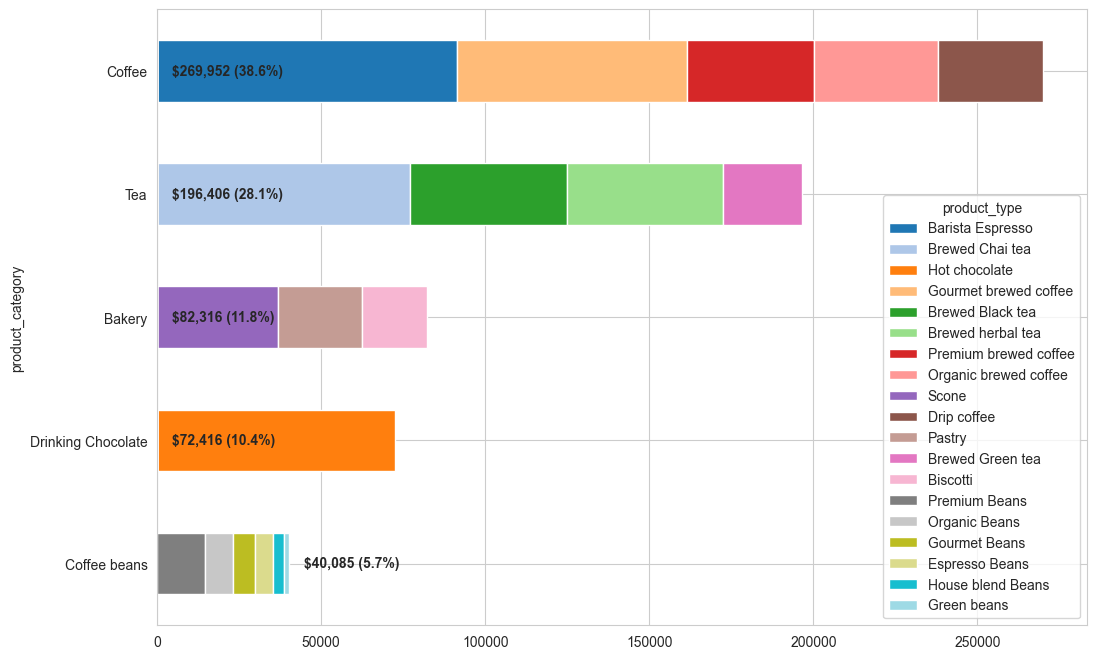

In [146]:
# Transform the flat table into a pivot table for stacked plotting
# Index will be Categories, Columns will be Types
pivot_df = top_performers.pivot_table(
    index="product_category", columns="product_type", values="sales", aggfunc="sum"
).fillna(0)

# Calculate Category Totals (Sales and total % share) for annotations
# We sum the 'sales' and 'revenue_share' for each category
cat_totals = (
    top_performers.groupby("product_category")
    .agg({"sales": "sum", "revenue_share": "sum"})
    .sort_values("sales", ascending=True)
)  # Sort to have largest at the top of the plot

# plot only top 5 categories
top_5_cat = cat_totals.tail(5)
# filter pivot_df to match top 5 categories
pivot_df = pivot_df.loc[top_5_cat.index]

# Filter columns: Remove columns that are all 0
pivot_df = pivot_df.loc[:, (pivot_df != 0).any(axis=0)]

# sort by product type
sorted_types = pivot_df.sum(axis=0).sort_values(ascending=False).index
pivot_df = pivot_df[sorted_types]

# plotting
ax = pivot_df.plot(
    kind="barh", stacked=True, figsize=(12, 8), colormap="tab20", edgecolor="white"
)

# annotation
# Create labels list using a list comprehension
labels = [
    f" ${s:,.0f} ({p:.1%})" for s, p in zip(top_5_cat.sales, top_5_cat.revenue_share)
]

# Apply labels to the last segment of the bars
ax.bar_label(ax.containers[-1], labels=labels, padding=8, fontweight="bold")

It is hard to recognize every product type. Let's try to make a interactive plot with plotly.

In [147]:
# [Cell: Category & Product Type Analysis]

# 1. Data Aggregation (Replaces previous manual groupby steps)
# We aggregate directly from the clean 'df' to get the necessary granularity.
plot_df = df.groupby(["product_category", "product_type"], as_index=False)[
    "sales"
].sum()

# 2. Metric Calculation
# Calculate total revenue once to use for shares.
total_revenue = plot_df["sales"].sum()

# Use 'transform' to add category-level totals directly to the dataframe.
# This eliminates the need for a separate 'cat_totals' dataframe and merging.
plot_df["category_total"] = plot_df.groupby("product_category")["sales"].transform(
    "sum"
)
plot_df["cat_share"] = plot_df["category_total"] / total_revenue
plot_df["type_share"] = plot_df["sales"] / total_revenue

# 3. Filter Top 5 Categories
# Logic: Find unique categories with the highest sales using the pre-calculated 'category_total'.
top_5_cats = (
    plot_df[["product_category", "category_total"]]
    .drop_duplicates()
    .nlargest(5, "category_total")
)
plot_df_filtered = plot_df[
    plot_df["product_category"].isin(top_5_cats["product_category"])
].copy()

# 4. Interactive Visualization
import plotly.express as px

fig = px.bar(
    plot_df_filtered,
    x="sales",
    y="product_category",
    color="product_type",
    orientation="h",
    title="<b>Revenue Breakdown by Category & Type</b><br><sup>Top 5 categories contribute the most to total revenue</sup>",
    hover_data={
        "product_category": False,
        "product_type": True,
        "sales": ":,.0f",
        "type_share": ":.2%",
        "cat_share": ":.1%",
    },
    labels={"sales": "Revenue ($)", "cat_share": "Category Share"},
)

fig.update_layout(
    yaxis={"categoryorder": "total ascending"}, template="plotly_white", height=500
)
fig.show()

Key Insights from Top 10 Products by Sales

Executive Summary:
The top 10 products account for ~79% of total revenue, with coffee, tea, hot chocolate, and bakery forming the core revenue pillars.

The top 4 items Barista Espresso, Brewed Chai tea, Hot chocolate, Gourmet brewed coffee contributed ~44.5% total revenue. We need to pay attention to these products about their quality and stock.

Scone is the only food that appeared on the ranking. If we want to rise the UPT, this could be the chance.
Action: bundling barista espresso and scone. 
        Place the scone on the most accessible place.



Noticed that hot cholocate is the third highest revenue-generating product type. Building on this insight, I will further inverstigate potential seasonality in hot chocolate sales.

In [148]:
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

target_product = "Hot chocolate"
product_df = df[df["product_type"] == target_product].copy()

product_df["Month"] = product_df["transaction_date"].dt.month
product_df["Month_Name"] = product_df["transaction_date"].dt.strftime(
    "%b"
)  # Jan, Feb...

# Seasonality
monthly_trend = (
    product_df.groupby(["Month", "Month_Name"])["transaction_qty"].sum().reset_index()
)

# above Average
avg_monthly_sales = monthly_trend["transaction_qty"].mean()
monthly_trend["vs_Average"] = monthly_trend["transaction_qty"] - avg_monthly_sales
monthly_trend["Status"] = monthly_trend["vs_Average"].apply(
    lambda x: "🔥 High Season" if x > 0 else "❄️ Low Season"
)

print(f"=== {target_product} Monthly Seasonality ===")
print(monthly_trend[["Month_Name", "transaction_qty", "Status"]])

=== Hot chocolate Monthly Seasonality ===
  Month_Name  transaction_qty         Status
0        Jan             2015  ❄️ Low Season
1        Feb             1964  ❄️ Low Season
2        Mar             2475  ❄️ Low Season
3        Apr             2952  🔥 High Season
4        May             3930  🔥 High Season
5        Jun             4121  🔥 High Season


Observation: Contrary to the traditional expectation of Hot Chocolate being a "Winter Warmer," the data reveals a counter-intuitive "Spring Surge." Sales do not drop off after February; instead, they accelerate significantly, nearly doubling from the February low (1,964 units) to a peak in June (4,121 units).

Actionable Takeaway: Do not de-stock chocolate inventory in March. Operations must prepare for peak consumption in Q2 (Apr–Jun). Marketing should shift messaging from "Warm Up" to "Treat Yourself" to align with this consumption behavior.

Now I am insterested in the most popular combinations of items.

In [149]:
# 1. 确定用于分组的列 (The Key)
group_cols = ["transaction_id"]

# 2. how many product types in one transaction
basket_sizes = df.groupby(group_cols)["product_type"].nunique()

single_item_orders = (basket_sizes == 1).sum()
multi_item_orders = (basket_sizes > 1).sum()
total_orders = len(basket_sizes)

print("-" * 40)
print(f"Total Transactions: {total_orders}")
print(
    f"Single-Item Baskets (Solo): {single_item_orders} ({single_item_orders/total_orders:.1%})"
)
print(
    f"Multi-Item Baskets (Combo): {multi_item_orders}  ({multi_item_orders/total_orders:.1%})"
)
print("-" * 40)

# 4. conclusion
if multi_item_orders == 0:
    print("❌ 结论：你是对的。")
    print("数据中不存在‘多品类订单’。每个 ID 真的只对应一种商品。")
    print("原因可能是：数据已经被聚合过了，或者系统真的不支持一次打两张单。")
else:
    print("✅ 结论：我们可以做组合分析！")
    print(f"虽然大部分是单买，但还有 {multi_item_orders} 个订单包含组合。")
    print("这足够我们挖掘‘最佳CP’了。")

----------------------------------------
Total Transactions: 149116
Single-Item Baskets (Solo): 149116 (100.0%)
Multi-Item Baskets (Combo): 0  (0.0%)
----------------------------------------
❌ 结论：你是对的。
数据中不存在‘多品类订单’。每个 ID 真的只对应一种商品。
原因可能是：数据已经被聚合过了，或者系统真的不支持一次打两张单。


Try to use timestamp as a hint to identify the same order.

In [150]:
from itertools import combinations
from collections import Counter

# 1. 创建“虚拟购物篮 ID” (The Time-Glue Strategy)
# 我们假设：同一天、同一时间点的交易，属于同一个顾客
# 注意：如果 transaction_time 精确到秒，效果最好。如果只到分，可能会把前后两个人的单子混在一起，但通过数量可以过滤。
basket_key = ["transaction_date", "transaction_time"]

# 2. 检查一下这种方法是否有效
# 统计每组(Date+Time)里有多少个不同的商品
basket_sizes = df.groupby(basket_key)["product_type"].nunique()

print(f"Total Time-Slots: {len(basket_sizes)}")
print(
    f"Slots with Multiple Items: {(basket_sizes > 1).sum()} (This is the combinations we are looking for!)"
)

# 3. 如果发现有多于1个商品的记录，就开始挖掘组合
if (basket_sizes > 1).sum() > 0:
    print("\n✅ Success! Found items bought together at the exact same time.")

    # 只提取那些“多商品”的时间点
    multi_item_timestamps = basket_sizes[basket_sizes > 1].index

    # 过滤出这些数据
    # 这里用 merge 或者 isin 都可以，isin 在多列索引时稍微麻烦点，我们直接再次 groupby
    # 为了效率，我们直接对所有数据做 groupby，然后只看 size > 1 的

    baskets = df.groupby(basket_key)["product_type"].apply(list)
    multi_item_baskets = baskets[baskets.apply(len) > 1]

    # 4. Pairwise Combinations
    combo_counter = Counter()

    for items in multi_item_baskets:
        # 去重并排序，确保 (Coffee, Bagel) 和 (Bagel, Coffee) 是同一个组合
        unique_items = sorted(list(set(items)))

        # 生成所有可能的两两配对
        for combo in combinations(unique_items, 2):
            combo_counter[combo] += 1

    # 5. 展示结果
    print("\n🏆 Top 10 Best-Selling Combinations (Based on Same Time):")
    print("-" * 50)
    for (item1, item2), count in combo_counter.most_common(10):
        print(f"🔸 {item1} + {item2} \t: appear {count} times")

else:
    print("\n❌ Failed. Even with Date+Time, every record is unique.")
    print("这说明数据可能被清洗过，或者真的是分批结账的。")

Total Time-Slots: 116129
Slots with Multiple Items: 29239 (This is the combinations we are looking for!)

✅ Success! Found items bought together at the exact same time.

🏆 Top 10 Best-Selling Combinations (Based on Same Time):
--------------------------------------------------
🔸 Barista Espresso + Regular syrup 	: appear 4943 times
🔸 Barista Espresso + Scone 	: appear 1900 times
🔸 Barista Espresso + Sugar free syrup 	: appear 1798 times
🔸 Brewed Chai tea + Scone 	: appear 1369 times
🔸 Gourmet brewed coffee + Scone 	: appear 1314 times
🔸 Hot chocolate + Scone 	: appear 937 times
🔸 Brewed herbal tea + Scone 	: appear 898 times
🔸 Brewed Chai tea + Pastry 	: appear 887 times
🔸 Brewed Black tea + Scone 	: appear 882 times
🔸 Biscotti + Brewed Chai tea 	: appear 847 times


Filter out syrup to see the real popular combinations.

In [151]:
# 假设 combo_counter 还是刚才那个 Counter 对象

print("🏆 Top 10 'Real Food' Combinations (Excluding Syrups):")
print("-" * 50)

real_food_combos = []

for (item1, item2), count in combo_counter.most_common(
    100
):  # 多取一点，因为前面可能被糖浆占满了
    # 过滤条件：如果任一商品名字里包含 'syrup'，就跳过
    if "syrup" in item1.lower() or "syrup" in item2.lower():
        continue

    # 打印前 10 个“纯食物/饮料”组合
    print(f"🔸 {item1} + {item2} \t: {count} times")
    real_food_combos.append(((item1, item2), count))

    if len(real_food_combos) >= 10:
        break

🏆 Top 10 'Real Food' Combinations (Excluding Syrups):
--------------------------------------------------
🔸 Barista Espresso + Scone 	: 1900 times
🔸 Brewed Chai tea + Scone 	: 1369 times
🔸 Gourmet brewed coffee + Scone 	: 1314 times
🔸 Hot chocolate + Scone 	: 937 times
🔸 Brewed herbal tea + Scone 	: 898 times
🔸 Brewed Chai tea + Pastry 	: 887 times
🔸 Brewed Black tea + Scone 	: 882 times
🔸 Biscotti + Brewed Chai tea 	: 847 times
🔸 Barista Espresso + Pastry 	: 827 times
🔸 Biscotti + Gourmet brewed coffee 	: 817 times


# Is there a relationship between quantity sold and unit price?

1) Statistical Analysis (Correlation)

In [152]:
# Calculate correlation between Unit Price and Transaction Quantity
correlation = df["unit_price"].corr(df["transaction_qty"])

print(f"Correlation Coefficient: {correlation:.4f}")

Correlation Coefficient: -0.1235


2) Visualization

/var/folders/h0/jdtympdj3h51dwn9nhx4pppw0000gn/T/ipykernel_13980/460507727.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




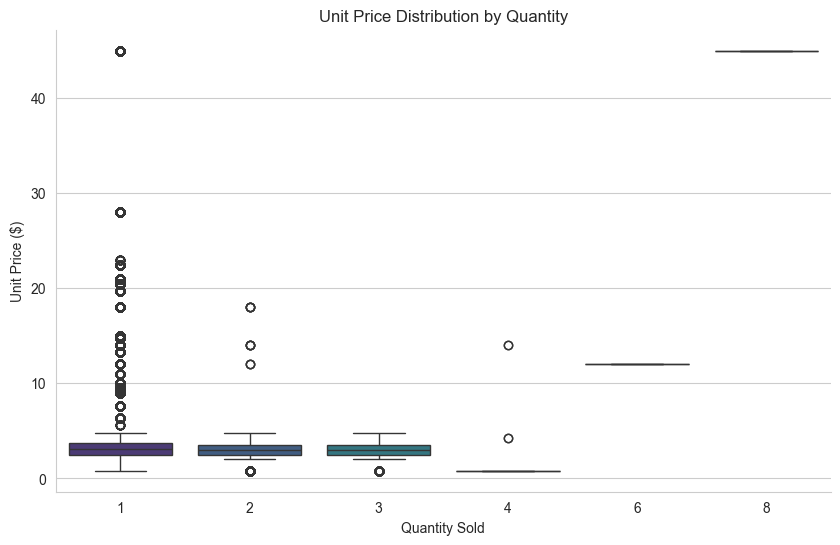

In [153]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x="transaction_qty", y="unit_price", palette="viridis")

plt.title("Unit Price Distribution by Quantity")
plt.xlabel("Quantity Sold")
plt.ylabel("Unit Price ($)")
sns.despine()

plt.show()

Noticed that most of the quantity sold is on 1. It is a typical skewed data. To look further into this, I will look at the unit price distribution first.

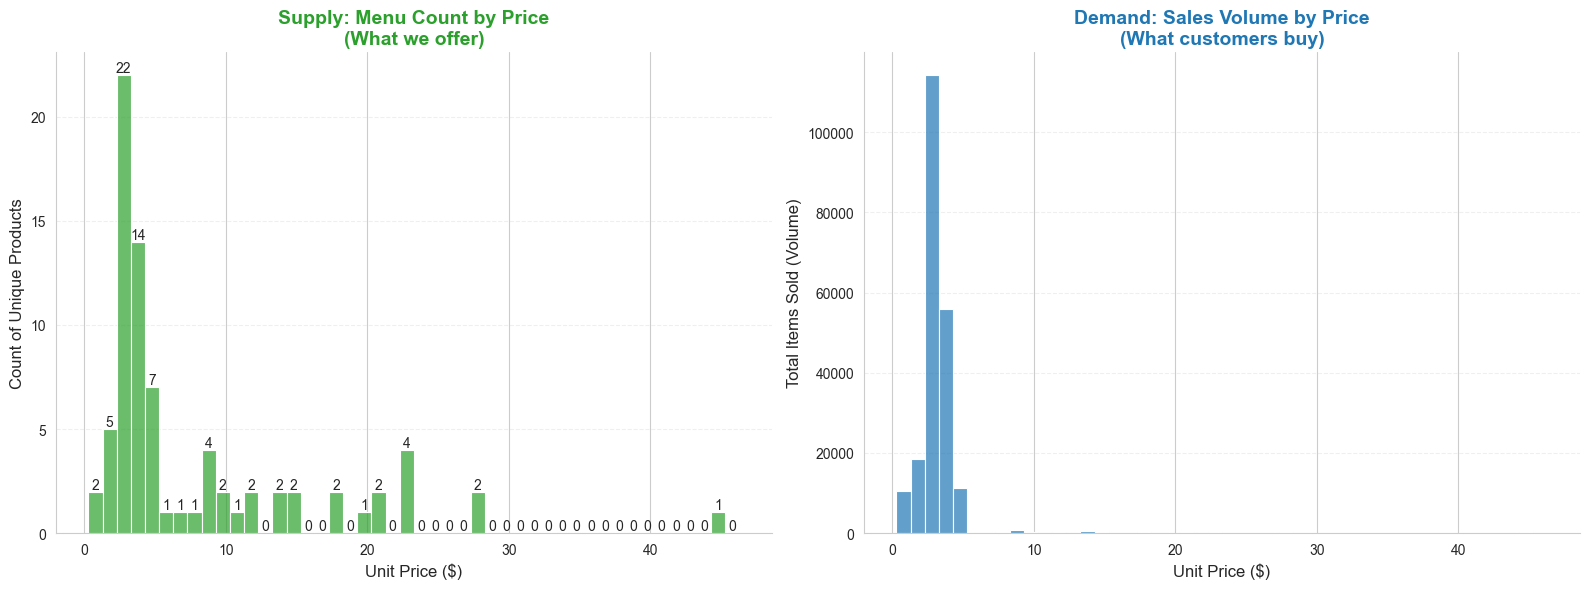

In [154]:
# 1. Prepare Data
# Supply Data: Unique Menu Items only
menu_df = df[["product_type", "unit_price"]].drop_duplicates()

# 2. Setup Canvas (1 Row, 2 Columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# --- Plot 1: Supply (Left Side) ---
# "What we offer"
sns.histplot(
    data=menu_df,
    x="unit_price",
    discrete=True,
    color="#2ca02c",  # Green for Supply
    alpha=0.7,
    ax=axes[0],  # Draw on the left subplot
)
axes[0].set_title(
    "Supply: Menu Count by Price\n(What we offer)",
    fontsize=14,
    fontweight="bold",
    color="#2ca02c",
)
axes[0].set_ylabel("Count of Unique Products", fontsize=12)
axes[0].set_xlabel("Unit Price ($)", fontsize=12)
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

# Add value labels for Supply
for container in axes[0].containers:
    axes[0].bar_label(container, fontsize=10)

# --- Plot 2: Demand (Right Side) ---
# "What customers buy"
sns.histplot(
    data=df,
    x="unit_price",
    weights="transaction_qty",  # Weight by quantity sold
    discrete=True,
    color="#1f77b4",  # Blue for Demand
    alpha=0.7,
    ax=axes[1],  # Draw on the right subplot
)
axes[1].set_title(
    "Demand: Sales Volume by Price\n(What customers buy)",
    fontsize=14,
    fontweight="bold",
    color="#1f77b4",
)
axes[1].set_ylabel("Total Items Sold (Volume)", fontsize=12)
axes[1].set_xlabel("Unit Price ($)", fontsize=12)
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

# 3. Final Polish
sns.despine()
plt.tight_layout()
plt.show()

Let's figure out what items are supplied the most and their price, and what items are purchased the most and their prices.

In [155]:
# [Analysis: Supply vs. Demand by $1 Price Bins]

# 1. Create $1 Price Bins (0-1, 1-2, ..., 9-10, 10+)
# ---------------------------------------------------------
bins = range(0, 12)  # 0, 1, 2 ... 11
labels = [f"${i}-${i+1}" for i in range(0, 10)] + ["$10+"]

# Create a new column 'price_bin'
df["price_bin"] = pd.cut(df["unit_price"], bins=bins, labels=labels, right=False)


# 2. Analyze Green Peak (Supply/Menu Side)
# ---------------------------------------------------------
# Count unique products in each bin
supply_bin_counts = df.groupby("price_bin", observed=False)["product_type"].nunique()

# Find the Peak Bin
green_peak_bin = supply_bin_counts.idxmax()
green_peak_count = supply_bin_counts.max()

# List products in this bin
green_peak_products = df[df["price_bin"] == green_peak_bin]["product_type"].unique()


# 3. Analyze Blue Peak (Demand/Sales Side)
# ---------------------------------------------------------
# Sum quantity sold in each bin
demand_bin_counts = df.groupby("price_bin", observed=False)["transaction_qty"].sum()

# Find the Peak Bin
blue_peak_bin = demand_bin_counts.idxmax()
blue_peak_volume = demand_bin_counts.max()

# Top sellers in this bin
blue_peak_top_items = (
    df[df["price_bin"] == blue_peak_bin]
    .groupby("product_type")["transaction_qty"]
    .sum()
    .nlargest(3)
)


# 4. Print Results
# ---------------------------------------------------------
print("=" * 50)
print("🟢 GREEN PEAK (Menu Focus)")
print(f"You offer the most variety in range: [{green_peak_bin}]")
print("=" * 50)
print(f"Product Count : {green_peak_count} unique items")
print(
    f"Typical Items : {', '.join(green_peak_products[:5])}..."
)  # Show first 5 to avoid clutter


print("\n" + "=" * 50)
print("🔵 BLUE PEAK (Customer Wallet)")
print(f"Customers buy the most volume in range: [{blue_peak_bin}]")
print("=" * 50)
print(f"Total Volume  : {blue_peak_volume:,.0f} items sold")
print(f"Top Drivers   :")
for product, qty in blue_peak_top_items.items():
    print(f"  - {product:<20}: {qty:,.0f} sold")

# 5. Mismatch Check
print("\n" + "-" * 50)
if green_peak_bin == blue_peak_bin:
    print("✅ PERFECT MATCH: Your menu structure fits customer spending habits.")
else:
    print(f"⚠️ MISMATCH DETECTED:")
    print(f"   -> You focused your menu on {green_peak_bin},")
    print(f"   -> But customers are heavily buying in {blue_peak_bin}.")
print("-" * 50)

🟢 GREEN PEAK (Menu Focus)
You offer the most variety in range: [$3-$4]
Product Count : 13 unique items
Typical Items : Gourmet brewed coffee, Brewed Chai tea, Scone, Hot chocolate, Brewed Black tea...

🔵 BLUE PEAK (Customer Wallet)
Customers buy the most volume in range: [$3-$4]
Total Volume  : 107,999 items sold
Top Drivers   :
  - Barista Espresso    : 15,313 sold
  - Gourmet brewed coffee: 12,815 sold
  - Organic brewed coffee: 8,702 sold

--------------------------------------------------
✅ PERFECT MATCH: Your menu structure fits customer spending habits.
--------------------------------------------------


By comparing the supply and need histagram, and analysis of the peak items, we found that the menu structure fits customer spending habits.

# What are the best-selling products?
Rank products by total quantity sold or total revenue.
	

In [156]:
best_selling = (
    df.groupby("product_detail")["transaction_qty"]
    .agg("sum")
    .sort_values(ascending=False)
)

print(best_selling.head(10))

product_detail
Earl Grey Rg                   4708
Dark chocolate Lg              4668
Morning Sunrise Chai Rg        4643
Latte                          4602
Peppermint Rg                  4564
Columbian Medium Roast Rg      4547
Traditional Blend Chai Rg      4512
Latte Rg                       4497
Our Old Time Diner Blend Sm    4484
Serenity Green Tea Rg          4477
Name: transaction_qty, dtype: int64


Seperate the size and product name into 2 columns, and check real best selling products.

In [157]:
# 1. 定义提取规则
# 逻辑：找结尾是 Sm, Rg, Lg 的单词
# \s+ 表示前面的空格
# (Sm|Rg|Lg) 表示这三个尺寸之一
# $ 表示字符串结尾
size_pattern = r"\s+(Sm|Rg|Lg)$"

# 2. 拆分：提取 Size
df["Size"] = df["product_detail"].str.extract(size_pattern, expand=False)

# 3. 清洗：把 Size 从原名字里删掉，得到干净的 Base Name
# 比如 "Latte Rg" -> "Latte"
df["Product_Base"] = (
    df["product_detail"].str.replace(size_pattern, "", regex=True).str.strip()
)

# 4. 填充空值 (Optional)
# 比如原本就是 "Latte" 的，提取出来 Size 是 NaN，我们可以填成 "Rg" 或者 "Unknown"
df["Size"] = df["Size"].fillna("Unknown")  # 如果你认为没标就是 Regular

# 5.重新聚合：见证真正的榜单 (True Best Sellers)
true_ranking = (
    df.groupby("Product_Base")["transaction_qty"].sum().sort_values(ascending=False)
)

print("🏆 TRUE Best Sellers (Combined Sizes):")
print("-" * 50)
print(true_ranking.head(15))

# 6. 顺便看看每种产品的尺寸偏好 (Size Preference)
print("\n📏 Size Preference Breakdown (Top 5 Products):")
print("-" * 50)
top_5_products = true_ranking.head(5).index
size_breakdown = (
    df[df["Product_Base"].isin(top_5_products)]
    .groupby(["Product_Base", "Size"])["transaction_qty"]
    .sum()
)
size_breakdown

🏆 TRUE Best Sellers (Combined Sizes):
--------------------------------------------------
Product_Base
Ethiopia                     13271
Our Old Time Diner Blend     13074
Columbian Medium Roast       13068
Brazilian                    13012
Jamaican Coffee River        12431
Morning Sunrise Chai          9157
Latte                         9099
Earl Grey                     9095
Peppermint                    9067
Sustainably Grown Organic     9003
Serenity Green Tea            8856
Traditional Blend Chai        8839
Dark chocolate                8793
Spicy Eye Opener Chai         8697
English Breakfast             8670
Name: transaction_qty, dtype: int64

📏 Size Preference Breakdown (Top 5 Products):
--------------------------------------------------


Product_Base              Size   
Brazilian                 Lg         4317
                          Rg         4385
                          Sm         4310
Columbian Medium Roast    Lg         4195
                          Rg         4547
                          Sm         4178
                          Unknown     148
Ethiopia                  Lg         4227
                          Rg         4393
                          Sm         4433
                          Unknown     218
Jamaican Coffee River     Lg         4395
                          Rg         4018
                          Sm         4018
Our Old Time Diner Blend  Lg         3997
                          Rg         4410
                          Sm         4484
                          Unknown     183
Name: transaction_qty, dtype: int64

Top 5 sellers are all single origin / blends coffee! In most of the coffee shops, latte will be the best seller, but in this coffee shop, customers are connoisseurs, they come here for coffee beans, not milk.

Secondary, tea are all named and specified. In the top 15 best selling products, except of the top 5 coffee, latte, and dark chocolate, the rest are all different kinds of tea. Tea is definetly the another main product.

Since we just found that about 8% order from Lower Manhattan add on flavor, I would like to see what product do customer add on to.

In [158]:
df[["product_category", "product_type"]].drop_duplicates().sort_values(
    "product_category"
)

,product_category,product_type
5,Bakery,Scone
28,Bakery,Pastry
22,Bakery,Biscotti
4598,Branded,Clothing
4033,Branded,Housewares
57,Coffee,Premium brewed coffee
31,Coffee,Organic brewed coffee
0,Coffee,Gourmet brewed coffee
8,Coffee,Barista Espresso
3,Coffee,Drip coffee


In [159]:
# 核心侦探步骤：找出所有“含糖”的订单
# 先找到买了 Flavours 的 basket_id
flavor_baskets_ids = df[df["Strict_Category"] == "Add-on"]["basket_id"].unique()

# 把这些订单的所有内容取出来
flavor_baskets_df = df[df["basket_id"].isin(flavor_baskets_ids)]

# 3. 看看糖浆的“宿主”是谁？
# 我们只关心 Drink (排除掉糖浆自己，也排除掉面包)
host_drinks = flavor_baskets_df[flavor_baskets_df["Strict_Category"] == "Drink"]

# 统计宿主饮料的排名
pairing_ranking = (
    host_drinks.groupby("Product_Base")["transaction_qty"]
    .sum()
    .sort_values(ascending=False)
)

print("🍯 SYRUP MAGNETS: Which drinks get the most Flavor Add-ons?")
print("-" * 60)
print(pairing_ranking.head(10))

# 4. 进阶：看看 Lower Manhattan 的特殊口味
# 专门看看 LM 店里，买了糖浆的人在喝什么
lm_flavors = host_drinks[host_drinks["store_location"] == "Lower Manhattan"]
lm_ranking = (
    lm_flavors.groupby("Product_Base")["transaction_qty"]
    .sum()
    .sort_values(ascending=False)
)

print("\n🏙️ Lower Manhattan Specific Pairing:")
print("-" * 60)
print(lm_ranking.head(5))

# 5. 验证：有没有人往“单品咖啡”里加糖浆？(Sacrilege Check!)
premium_beans = [
    "Jamaican Coffee River",
    "Ethiopia",
    "Columbian Medium Roast",
    "Lemon Grass",
    "Sustainably Grown Organic",
    "English Breakfast",
    "Brazilian",
]
sacrilege_count = host_drinks[host_drinks["Product_Base"].isin(premium_beans)][
    "transaction_qty"
].sum()
print(f"\n😱 'Sacrilege' Count (Syrup in Premium Beans): {sacrilege_count}")

🍯 SYRUP MAGNETS: Which drinks get the most Flavor Add-ons?
------------------------------------------------------------
Product_Base
Latte                     4463
Cappuccino                4237
Espresso shot             1955
Dark chocolate              18
Jamaican Coffee River       15
Ethiopia                     8
Peppermint                   8
Columbian Medium Roast       6
Lemon Grass                  6
Morning Sunrise Chai         6
Name: transaction_qty, dtype: int64

🏙️ Lower Manhattan Specific Pairing:
------------------------------------------------------------
Product_Base
Latte             2022
Cappuccino        1918
Espresso shot      893
Ethiopia             8
Dark chocolate       6
Name: transaction_qty, dtype: int64

😱 'Sacrilege' Count (Syrup in Premium Beans): 45


Most of the syrup are paired with Latte, Cappuccino and Espresso shot. Only 45 orders of syrups are paired with premium beand or some tea. Lower Manhattan contributed half of add ons on Latte and cappuccino.

# Are there seasonal trends in monthly sales?
Identify peaks and dips in monthly revenue to uncover seasonality.

/var/folders/h0/jdtympdj3h51dwn9nhx4pppw0000gn/T/ipykernel_13980/3272058643.py:35: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



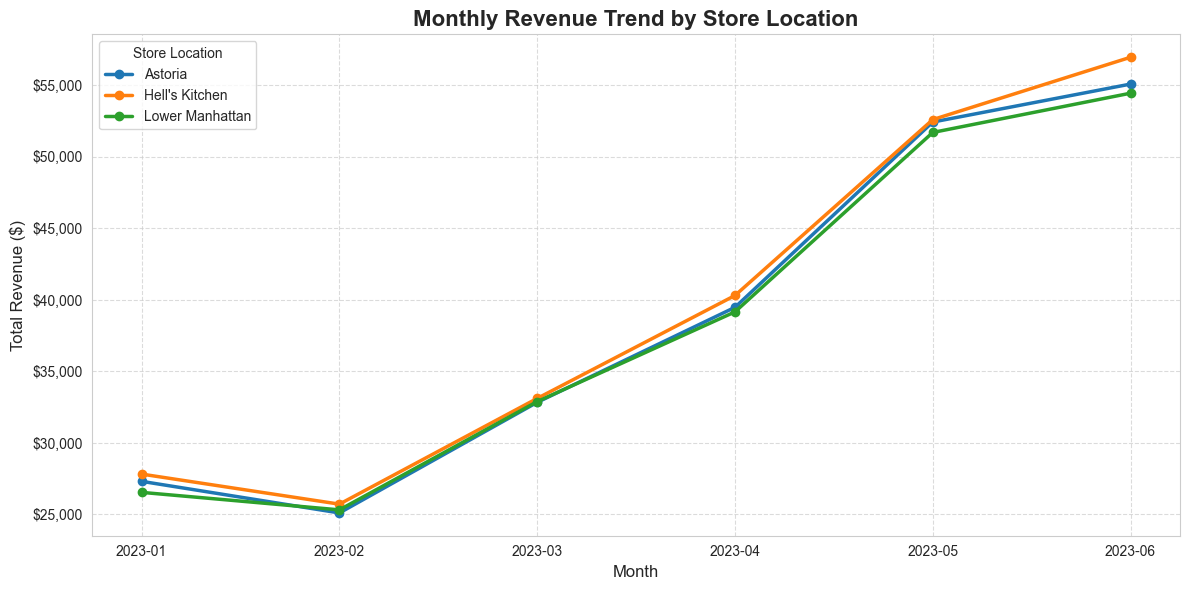

📅 Monthly Revenue Data:
--------------------------------------------------
store_location     Astoria Hell's Kitchen Lower Manhattan
Month_Year                                               
2023-01         $27,313.66     $27,820.65      $26,543.43
2023-02         $25,105.34     $25,719.80      $25,320.05
2023-03         $32,835.43     $33,110.57      $32,888.68
2023-04         $39,477.61     $40,304.14      $39,159.33
2023-05         $52,428.76     $52,598.93      $51,700.07
2023-06         $55,083.11     $56,957.08      $54,445.69

📈 Month-over-Month Growth Rate:
--------------------------------------------------
store_location Astoria Hell's Kitchen Lower Manhattan
Month_Year                                           
2023-01              -              -               -
2023-02          -8.1%          -7.6%           -4.6%
2023-03         +30.8%         +28.7%          +29.9%
2023-04         +20.2%         +21.7%          +19.1%
2023-05         +32.8%         +30.5%          +32.0%

In [160]:
# 1. 确保日期格式正确
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# 2. 提取月份 (Month)
# 把它变成 '2023-01' 这样的格式方便排序
df["Month_Year"] = df["transaction_date"].dt.to_period("M")

# 4. 按“月份”和“门店”聚合
monthly_revenue = df.groupby(["Month_Year", "store_location"])["sales"].sum().unstack()

# 5. 画图：一目了然的折线图
plt.figure(figsize=(12, 6))

# 使用 Seaborn 风格
sns.set_style("whitegrid")

# 画线
for store in monthly_revenue.columns:
    plt.plot(
        monthly_revenue.index.astype(str),
        monthly_revenue[store],
        marker="o",
        linewidth=2.5,
        label=store,
    )

plt.title("Monthly Revenue Trend by Store Location", fontsize=16, fontweight="bold")
plt.ylabel("Total Revenue ($)", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.legend(title="Store Location")
plt.grid(True, linestyle="--", alpha=0.7)

# 格式化 Y 轴 (显示为 $K)
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(["${:,.0f}".format(x) for x in current_values])

plt.tight_layout()
plt.show()

# 6. 打印具体数据表 (方便看涨跌幅)
print("📅 Monthly Revenue Data:")
print("-" * 50)
print(monthly_revenue.map(lambda x: f"${x:,.2f}"))

# 7. 计算月环比增长率 (MoM Growth) - 看看生意是在变好还是变坏？
mom_growth = monthly_revenue.pct_change()
print("\n📈 Month-over-Month Growth Rate:")
print("-" * 50)
print(mom_growth.map(lambda x: f"{x:+.1%}" if pd.notnull(x) else "-"))

The plot uncovered a huge seasonality. Q1 is low and Q2 grew quickly. Feburary is low because it is shorter than Jan.

Despite the seasonality, the coffee shop is probably on its climbing stage. The business in growing well for all of 3 stores.

Let's figure out which product contributed the most growth in Q2.

In [161]:
# 1. 准备数据 & 清洗 Product_Base
df["Month"] = df["transaction_date"].dt.month
size_pattern = r"\s+(Sm|Rg|Lg)$"

df["Product_Base"] = (
    df["product_detail"].str.replace(size_pattern, "", regex=True).str.strip()
)

# 2. 提取 2月 和 6月
feb_data = df[df["Month"] == 2]
jun_data = df[df["Month"] == 6]

# 3. 计算 Baseline Growth (全店基准)
total_feb_qty = feb_data["transaction_qty"].sum()
total_jun_qty = jun_data["transaction_qty"].sum()

baseline_growth = (total_jun_qty - total_feb_qty) / total_feb_qty
print(f"📈 STORE BASELINE GROWTH (Feb -> Jun): {baseline_growth:.1%}")
print("(Any product growing less than this is technically 'losing share' in summer)")
print("-" * 60)

# 4. 计算每个产品的增长
feb_sales = feb_data.groupby("Product_Base")["transaction_qty"].sum()
jun_sales = jun_data.groupby("Product_Base")["transaction_qty"].sum()

comparison = pd.DataFrame({"Feb_Qty": feb_sales, "Jun_Qty": jun_sales}).fillna(0)

# 过滤掉销量太小的产品 (避免 1个变2个 这种 100% 增长的干扰)
comparison = comparison[comparison["Feb_Qty"] > 50]

# 5. 计算相对表现
comparison["Growth_Rate"] = (
    comparison["Jun_Qty"] - comparison["Feb_Qty"]
) / comparison["Feb_Qty"]
comparison["Vs_Baseline"] = comparison["Growth_Rate"] - baseline_growth

# 6. 分组展示：谁是赢家，谁是输家？

# A. 夏季赢家 (Summer Winners) - 跑赢大盘
winners = comparison[comparison["Vs_Baseline"] > 0].sort_values(
    by="Vs_Baseline", ascending=False
)

# B. 夏季输家 (Summer Laggards) - 跑输大盘
laggards = comparison[comparison["Vs_Baseline"] < 0].sort_values(
    by="Vs_Baseline", ascending=True
)

print("\n🏆 SUMMER STARS (Growing Faster than the Store):")
print("(Likely Iced / Cold / Seasonal items)")
print("-" * 75)
print(
    winners[["Feb_Qty", "Jun_Qty", "Growth_Rate", "Vs_Baseline"]]
    .map(lambda x: f"{x:.1%}" if abs(x) < 10 else f"{int(x)}")
    .head(8)
)

print("\n❄️ SUMMER LAGGARDS (Growing Slower than the Store):")
print("(Likely Hot Coffee / Heavy Pastries)")
print("-" * 75)
print(
    laggards[["Feb_Qty", "Jun_Qty", "Growth_Rate", "Vs_Baseline"]]
    .map(lambda x: f"{x:.1%}" if abs(x) < 10 else f"{int(x)}")
    .head(8)
)

# 7. 专门看看你的“精品豆”表现如何
premium_beans = [
    "Ethiopia",
    "Jamaican Coffee River",
    "Columbian Medium Roast",
    "Our Old Time Diner Blend",
]
print("\n☕ Premium Beans Check:")
print("-" * 75)
print(
    comparison.loc[comparison.index.intersection(premium_beans)][
        ["Growth_Rate", "Vs_Baseline"]
    ].map(lambda x: f"{x:.1%}")
)

📈 STORE BASELINE GROWTH (Feb -> Jun): 116.3%
(Any product growing less than this is technically 'losing share' in summer)
------------------------------------------------------------

🏆 SUMMER STARS (Growing Faster than the Store):
(Likely Iced / Cold / Seasonal items)
---------------------------------------------------------------------------
                         Feb_Qty Jun_Qty Growth_Rate Vs_Baseline
Product_Base                                                    
Scottish Cream Scone         202     467      131.2%       14.9%
Our Old Time Diner Blend    1381    3179      130.2%       13.9%
Oatmeal Scone                190     431      126.8%       10.5%
Carmel syrup                 270     607      124.8%        8.5%
Ethiopia                    1455    3256      123.8%        7.5%
Lemon Grass                  906    2027      123.7%        7.4%
Almond Croissant             203     454      123.6%        7.3%
Columbian Medium Roast      1427    3171      122.2%        5.9%

❄️ 